In [1]:
import os
import torch
from torch import nn
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from tqdm import tqdm 
from torch.nn.functional import one_hot
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Load pretrained tiny-imagenet weights into the model for tinyimagenet.

In [4]:
def get_model_for_split(split_num, path_to_pretrained_weights_folder, device=device):
    state_dict = torch.load(path_to_pretrained_weights_folder + "tinyimagenet_" + str(split_num) + ".pth",
                        map_location=torch.device(device)) # <- Maybe this arg should only be there for cpu?
    state_dict = strip_state_dict(state_dict)

    # Instantiating a model for tinyimagenet and putting it into EVAL MODE!
    model = classifier32(num_classes=20)
    model = model.to(device)
    model.load_state_dict(state_dict)
    model.eval()

    return model

Load in the tiny-imagenet-200 datasets and put them into dataloaders

In [7]:
def plot_image_i(i, dataset, mean, std):
    img, label, uq_idx = dataset[i]
    # Unnormalize
    img = img*np.array(std)[:, None, None] + np.array(mean)[:, None, None]
    
    # The image is clipped due to numerical imprecision.
    plt.imshow(np.clip(img.permute(1,2,0).numpy(), 0.0, 1.0))
    print(label, uq_idx)
    plt.show()

def plot_image_on_ax(ax, normalized_img, mean, std):
    if normalized_img.requires_grad:
        normalized_img = normalized_img.detach()
    img = normalized_img*np.array(std)[:, None, None] + np.array(mean)[:, None, None]
    ax.imshow(np.clip(img.permute(1,2,0).numpy(), 0.0, 1.0))

def plot_image(normalized_img, mean, std):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    plot_image_on_ax(ax, normalized_img, mean=mean, std=std)
    plt.show()
    


In [9]:
def get_csr_dataloader_for_split(split_num, splits, dataset, batch_size=100, shuffle=True):
    tiny_img_net_split = splits[split_num] 
    csr_dataset = subsample_classes(dataset, tiny_img_net_split)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def evaluate_csr_accuracy(model, dataloader, device):
    num_correct = 0
    for i, (input_batch, target_batch, _) in enumerate(dataloader):
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        logits = model(input_batch)
        preds = torch.argmax(logits, dim=-1)
        num_correct += torch.sum((torch.eq(preds, target_batch)))
        print(f"{(i+1)/len(dataloader)*100}% done")

    return (num_correct/len(dataloader.dataset)).item()

A "function" for evaluating average OSR accuracy across all 5 splits. The results match the ones found in table 5 of the paper (second to last row)

In [10]:
def get_avg_csr_acc_across_splits(path_to_pretrained_weights_folder, device, tin_val_root_dir, test_transform, splits, batch_size=100, shuffle=True):
    accs = []
    for split_num in tqdm(range(5)):
        dataset = TinyImageNet(root=tin_val_root_dir, transform=test_transform)
        model = get_model_for_split(split_num, path_to_pretrained_weights_folder, device=device)
        dataloader = get_csr_dataloader_for_split(split_num, splits, dataset, batch_size=batch_size, shuffle=shuffle)
        acc = evaluate_csr_accuracy(model, dataloader, device=device)
        accs += acc,
    
    return sum(accs)/len(accs)

#### Verify csr accuracy from the paper

In [11]:
#get_avg_csr_acc_across_splits()

In [12]:
def get_osr_dataloader_for_split(split_num, tin_val_root_dir, test_transform, batch_size=100, shuffle=True): 
    dataset = TinyImageNet(root=tin_val_root_dir, transform=test_transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def evaluate_osr_auroc(model, dataloader, split_num, splits, device, logdir=None):
    targets = []
    all_csr_targets = []
    mls_scores = []
    all_logits = []
    for i, (input_batch, target_batch, _) in enumerate(dataloader):
        all_csr_targets += target_batch,
        input_batch = input_batch.to(device)
        target_batch = (~(sum(target_batch == i for i in splits[split_num]).bool()))
        target_batch = target_batch.to(device)
        logits = model(input_batch).detach().to('cpu')
        all_logits += logits,
        #logits = nn.Softmax(dim=-1)(logits) # Test for comparing with MSP
        mls_for_osr = -logits.max(dim=-1)[0] # (-) because low osr-score corresponds to known class
        targets += target_batch.tolist()
        mls_scores += mls_for_osr.tolist()
        print(f"{int((i+1)/len(dataloader)*100)}% done")

    if logdir is not None:
        torch.save(torch.cat(all_logits), logdir + "tin_vgg32_all_logit_scores_split_" + str(split_num) + ".pt")
        torch.save(all_csr_targets, logdir + "tin_vgg32_all_csr_targets_split_" + str(split_num) + ".pt")

    return roc_auc_score(targets, mls_scores)

def get_avg_osr_auroc_across_splits(path_to_pretrained_weights_folder, tin_val_root_dir, test_transform, device, logdir=None, batch_size=100, shuffle=True):
    aurocs = []
    for split_num in tqdm(range(5)):
        model = get_model_for_split(split_num, path_to_pretrained_weights_folder, device=device)
        dataloader = get_osr_dataloader_for_split(split_num, tin_val_root_dir, test_transform, batch_size=batch_size, shuffle=shuffle)
        auroc = evaluate_osr_auroc(model, dataloader, split_num, splits, device=device, logdir=logdir)
        aurocs += auroc,
    
    return sum(aurocs)/len(aurocs)

#### Verify the osr auroc from the paper

In [13]:
#get_avg_osr_auroc_across_splits(logdir = path_to_logits)

# Some primitive adversarial attacks

In [14]:
def fgsm(model, x, y, eps, loss_func):
    x.requires_grad = True
    loss = loss_func(model(x), y)
    loss.backward()
    return x + eps*torch.sign(x.grad)

def fp_osr_fgsm(model, x, eps=0.05):
    return fgsm(model, x, None, eps, lambda y_hat, y: torch.linalg.norm(y_hat, dim=-1, ord=torch.inf))

def fn_osr_fgsm(model, x, eps=0.05):
    return fgsm(model, x, None, -eps, lambda y_hat, y: torch.linalg.norm(y_hat, dim=-1, ord=torch.inf))

In [15]:
def get_logit_stats(model, split_num, device, tin_val_root_dir, test_transform): # Stats are for the train data
    dataloader = get_csr_dataloader_for_split(split_num, splits, dataset=TinyImageNet(root=tin_val_root_dir, transform=test_transform))
    running_max = torch.zeros(20).to(device) - torch.inf
    running_min = torch.zeros(20).to(device) + torch.inf
    running_sum = torch.zeros(20).to(device)
    running_cnt = torch.zeros(20).to(device)

    for i, (inputs, targets, _) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits = test_model(inputs).detach()
        mask = one_hot(targets, num_classes=20)
        masked_logits = logits * mask
        this_max = torch.amax(masked_logits, dim=0)
        torch.amax(torch.stack((running_max, this_max)), dim=0, out=running_max)
        this_min = torch.amin(torch.where(masked_logits == 0, torch.inf, masked_logits), dim=0)
        torch.amin(torch.stack((running_min, this_min)), dim=0, out=running_min)
        this_sum = torch.sum(masked_logits, dim=0)
        torch.sum(torch.stack((running_sum, this_sum)), dim=0, out=running_sum)
        this_cnt = torch.sum(mask, dim=0)
        torch.sum(torch.stack((running_cnt, this_cnt)), dim=0, out=running_cnt)
        print(f"{int((i+1)/len(dataloader)*100)}% done")
    return running_max, running_min, running_sum/running_cnt

def plot_logit_change(model, x, x_prime, stats):
    max, min, avg = stats
    before = model(x)[0].tolist()
    after = model(x_prime)[0].tolist()
    logit_range = np.arange(len(before))
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    ax.bar(logit_range-0.2, before, 0.4, label="Logits before perturbation", zorder=-1)
    ax.bar(logit_range+0.2, after, 0.4, label="Logits after perturbation", zorder=-1)
    ax.scatter(logit_range, max.tolist(), marker='_', label="max", zorder=1, c='r', alpha=1)
    ax.scatter(logit_range, min.tolist(), marker='_', label='min', zorder=1, c='b', alpha=1)
    ax.scatter(logit_range, avg.tolist(), marker='_', label='avg', zorder=1, c='g', alpha=1)
    plt.legend()
    plt.show()

In [16]:
def show_k_adv_attacks_fp_osr(k, split_num, stats=None):
    model = get_model_for_split(split_num, path_to_pretrained_weights_folder).to('cpu')
    if stats is None:
        stats = get_logit_stats(model, split_num)
    k_cnt = 0
    for i in range(200):
        if i not in tiny_img_net_splits[split_num]:
            x = TinyImageNet(root=tin_val_root_dir, transform=test_transform)[i*50 + 9][0][None,:,:] # 9
            x_prime = fp_osr_fgsm(model, x)
            fig, ax = plt.subplots(1,2, figsize=(10, 5))
            plot_image_on_ax(ax[0], x[0])
            plot_image_on_ax(ax[1], x_prime[0])
            plt.show()
            plot_logit_change(model, x, x_prime, stats)
            k_cnt += 1
        if k_cnt >= k:
            break

In [17]:
test_split_num = 0
test_model = get_model_for_split(test_split_num, path_to_pretrained_weights_folder)

In [18]:
test_stats = get_logit_stats(test_model, test_split_num)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done


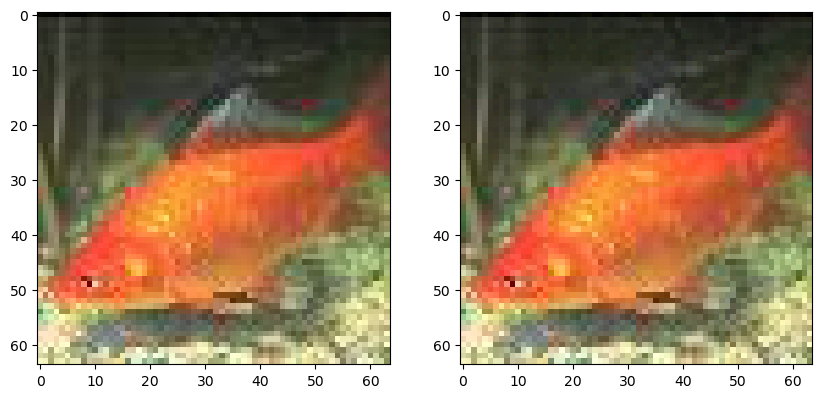

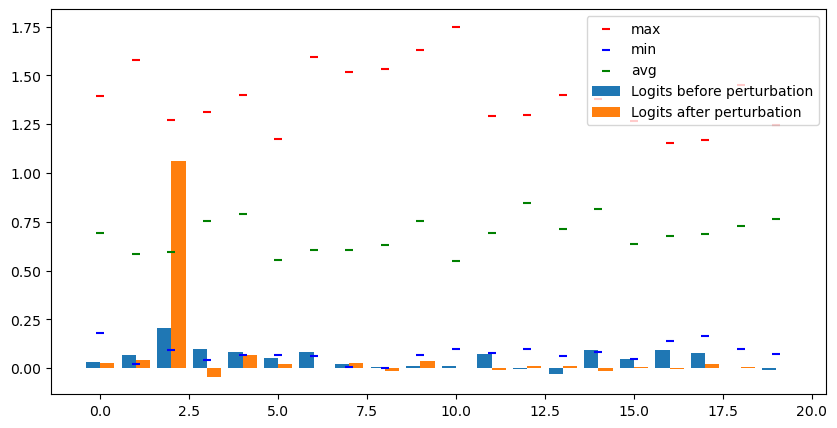

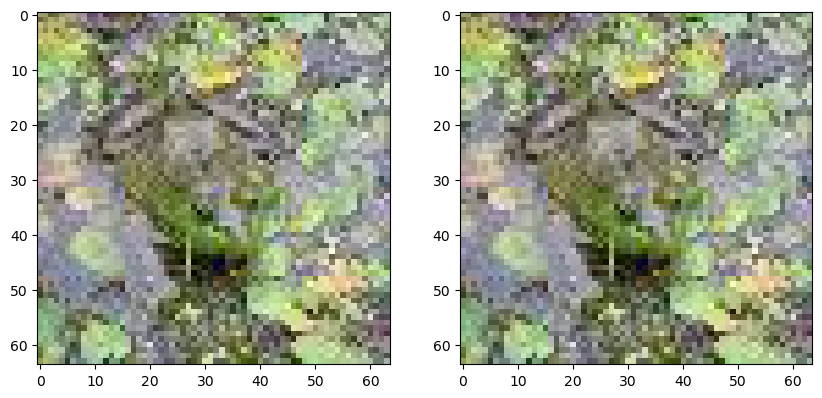

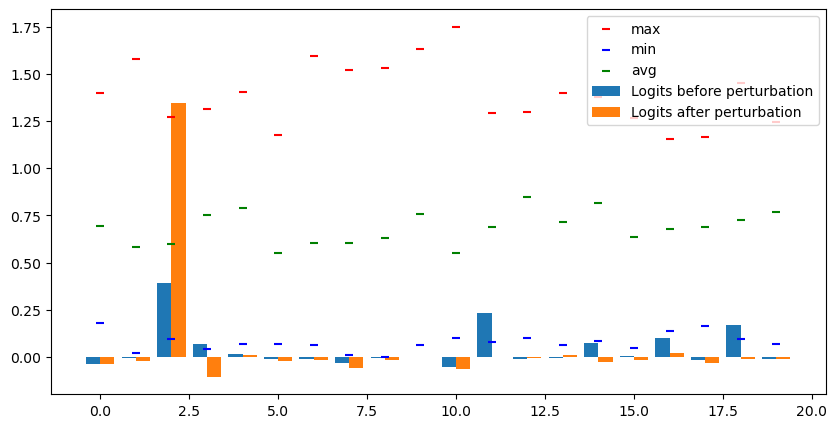

In [19]:
show_k_adv_attacks_fp_osr(2, test_split_num, stats=test_stats)

In [20]:
def show_k_adv_attacks_fn_osr(k, split_num, stats=None):
    model = get_model_for_split(split_num, path_to_pretrained_weights_folder).to('cpu')
    if stats is None:
        stats = get_logit_stats(model, split_num)
    k_cnt = 0
    for i in range(200):
        if i in tiny_img_net_splits[split_num]:
            print("__________________________________________________________________________")
            x = TinyImageNet(root=tin_val_root_dir, transform=test_transform)[i*50 + 9][0][None,:,:] # 9
            x_prime = fn_osr_fgsm(model, x)
            fig, ax = plt.subplots(1,2, figsize=(10, 5))
            plot_image_on_ax(ax[0], x[0])
            plot_image_on_ax(ax[1], x_prime[0])
            plt.show()
            plot_logit_change(model, x, x_prime, stats)
            k_cnt += 1
            print("__________________________________________________________________________")
        if k_cnt >= k:
            break

__________________________________________________________________________


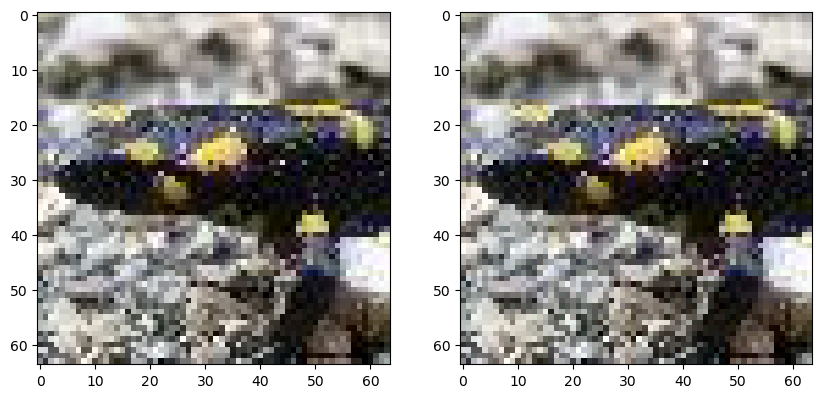

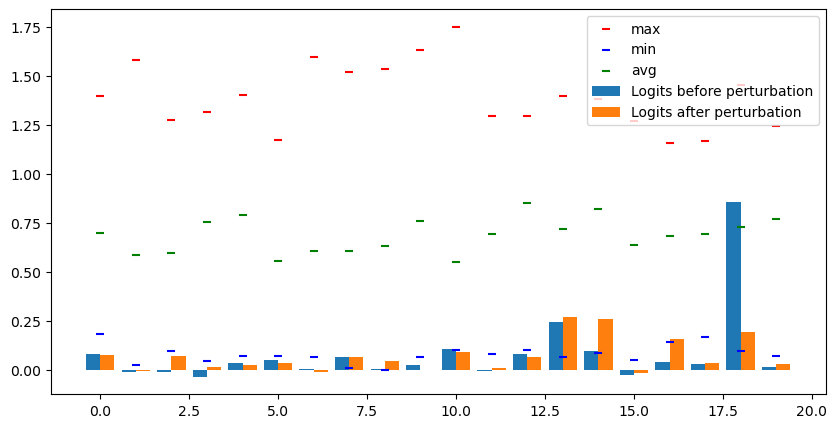

__________________________________________________________________________
__________________________________________________________________________


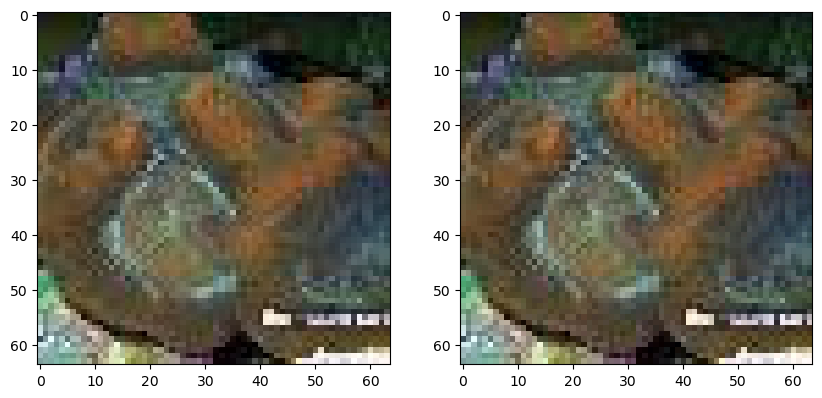

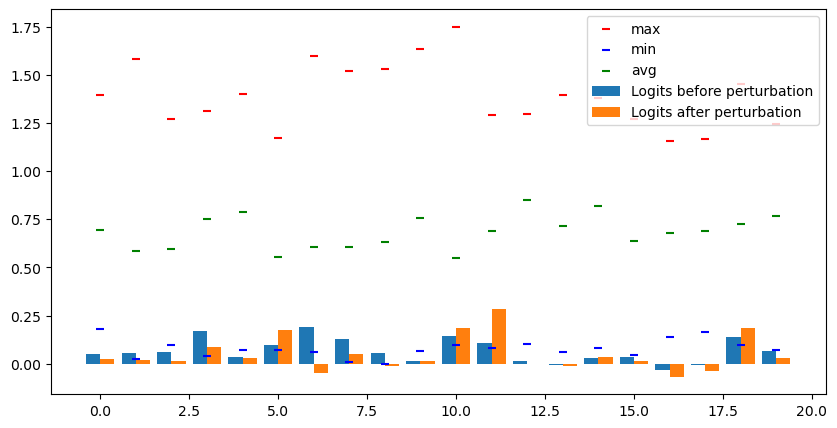

__________________________________________________________________________
__________________________________________________________________________


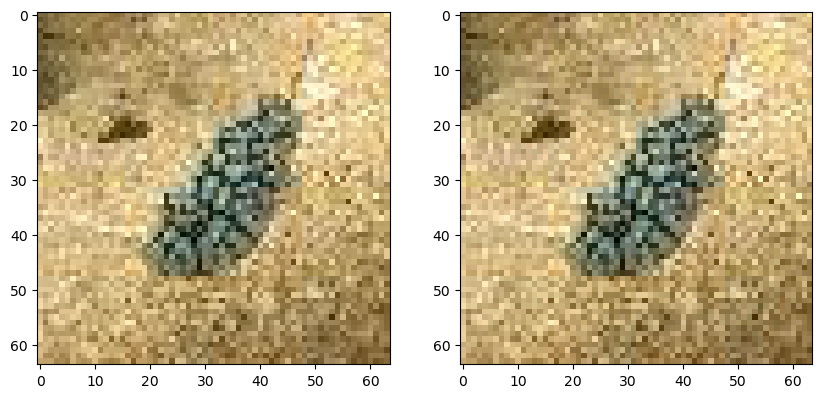

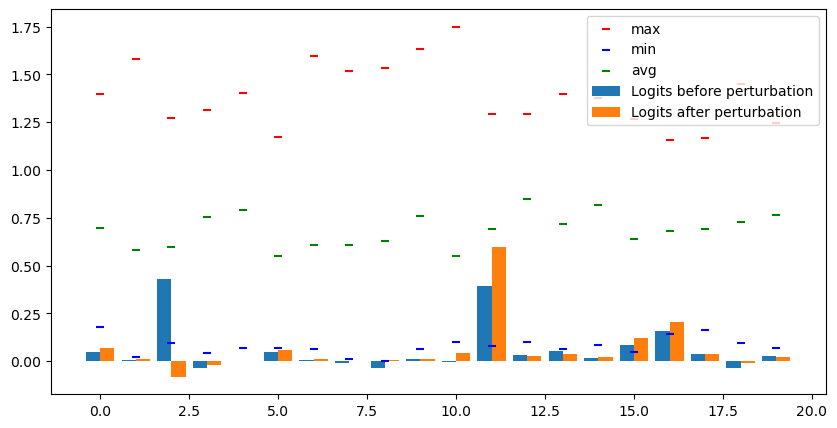

__________________________________________________________________________
__________________________________________________________________________


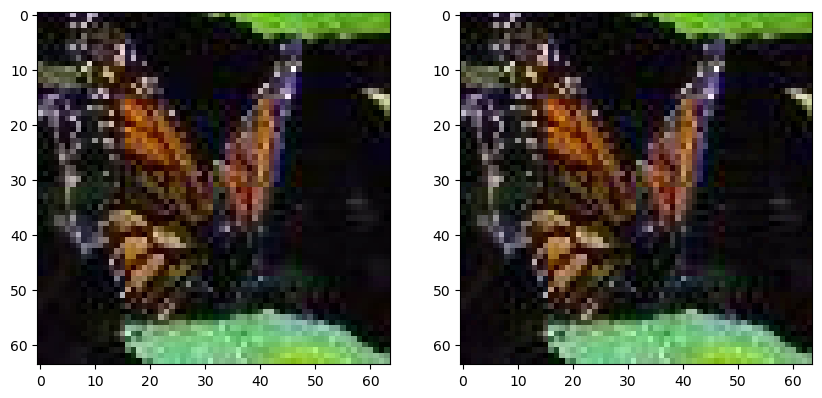

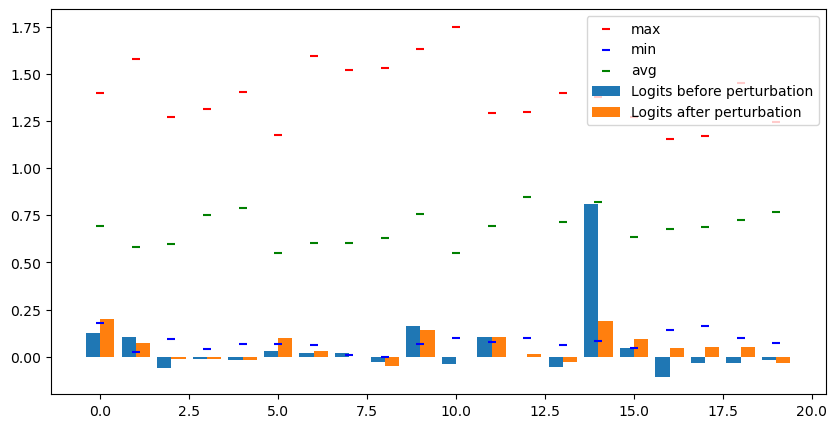

__________________________________________________________________________
__________________________________________________________________________


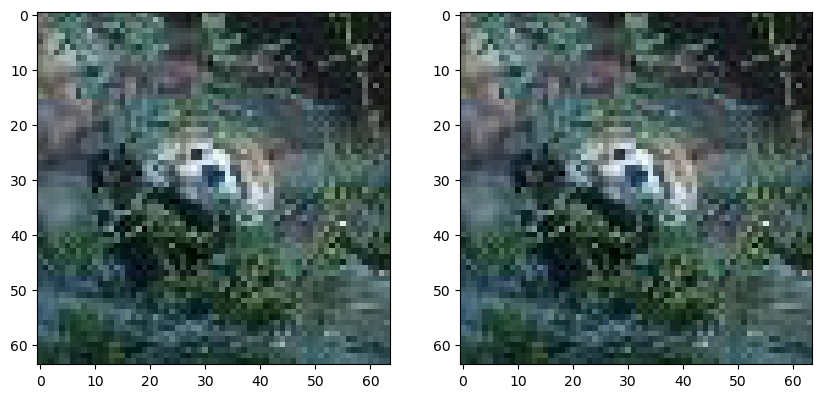

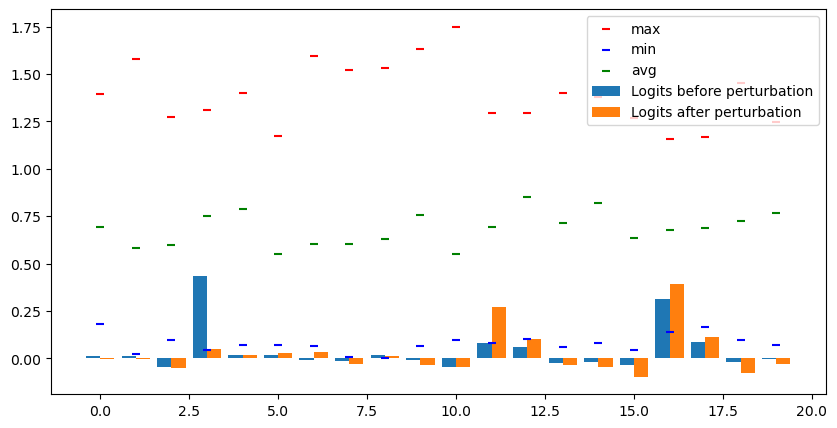

__________________________________________________________________________
__________________________________________________________________________


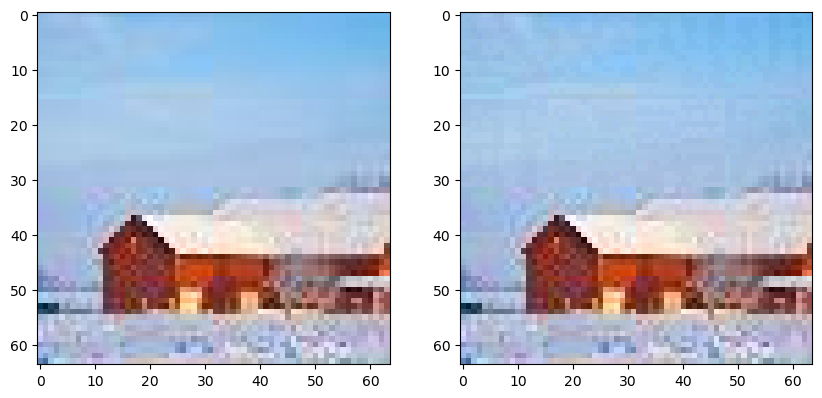

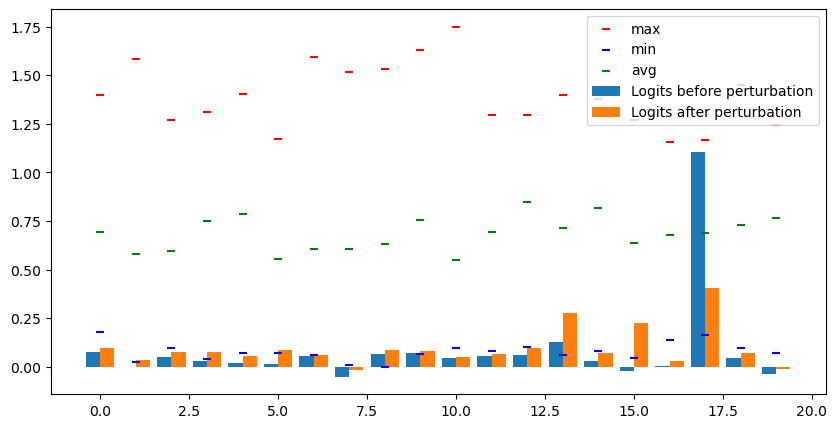

__________________________________________________________________________
__________________________________________________________________________


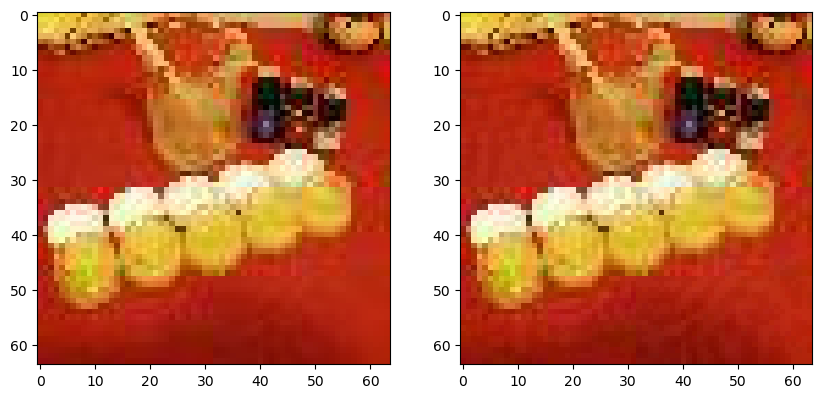

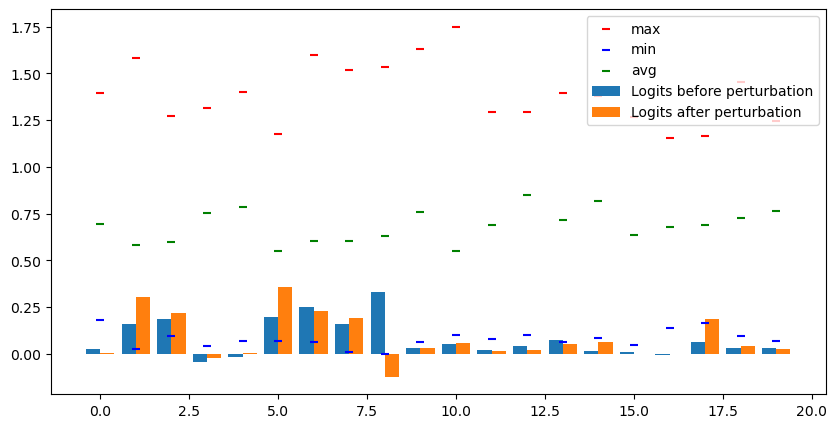

__________________________________________________________________________
__________________________________________________________________________


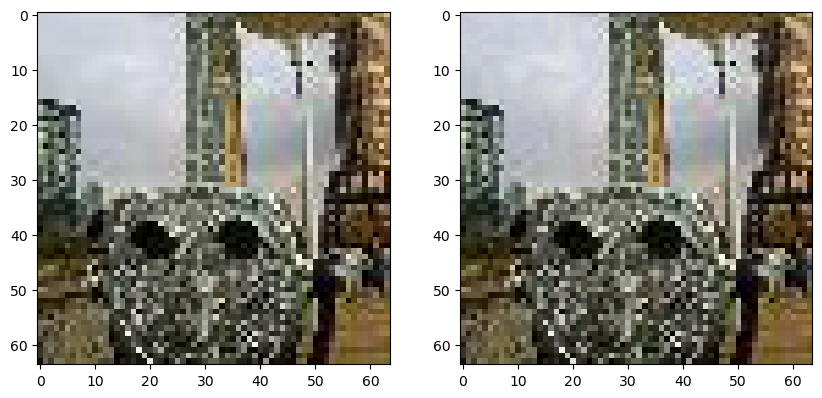

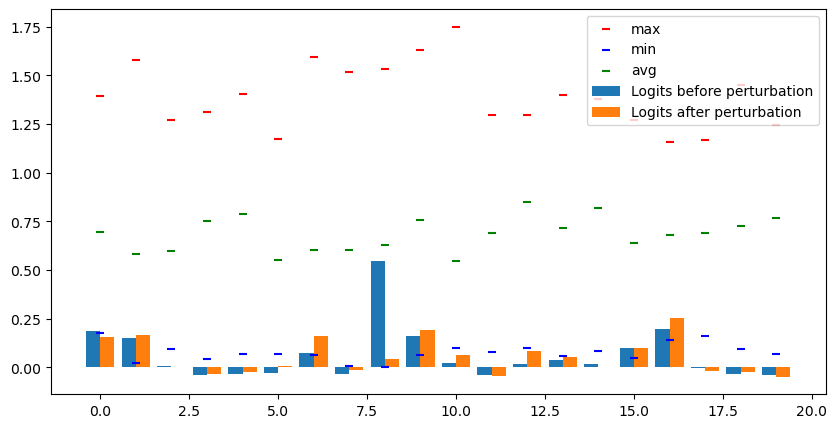

__________________________________________________________________________
__________________________________________________________________________


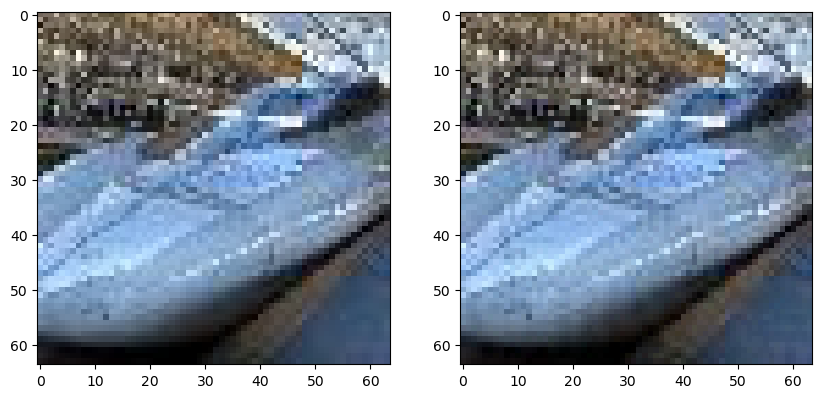

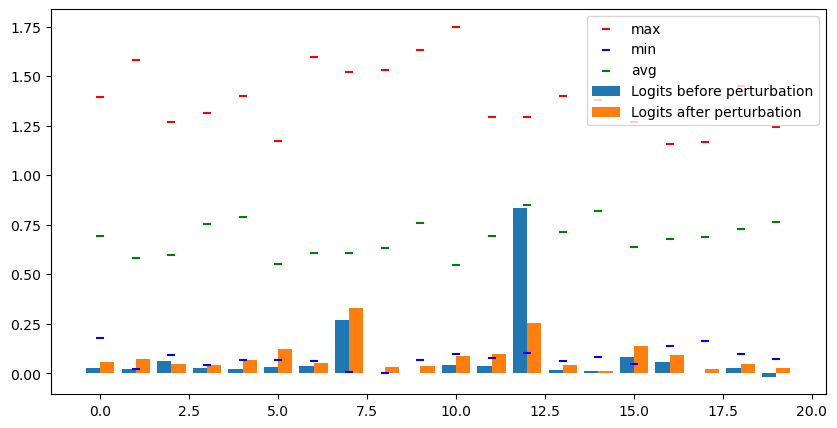

__________________________________________________________________________
__________________________________________________________________________


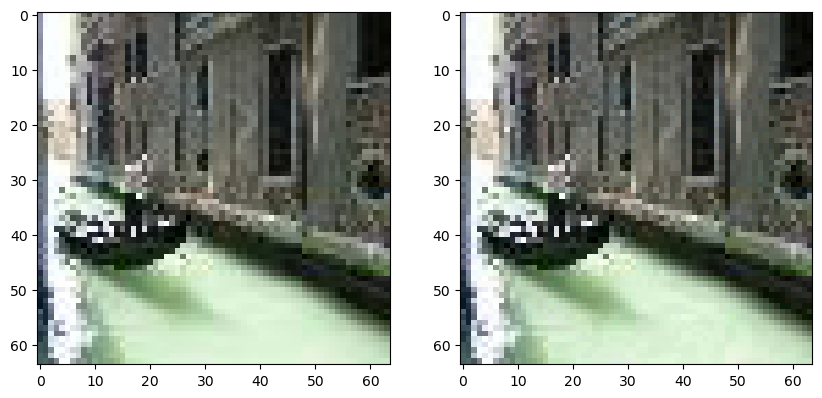

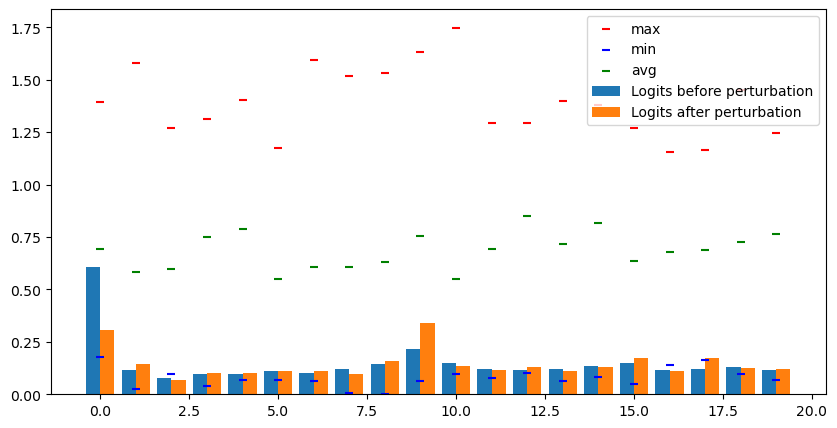

__________________________________________________________________________
__________________________________________________________________________


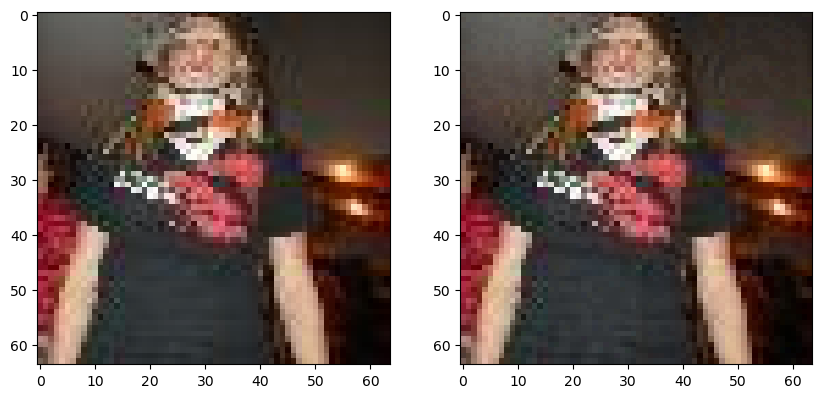

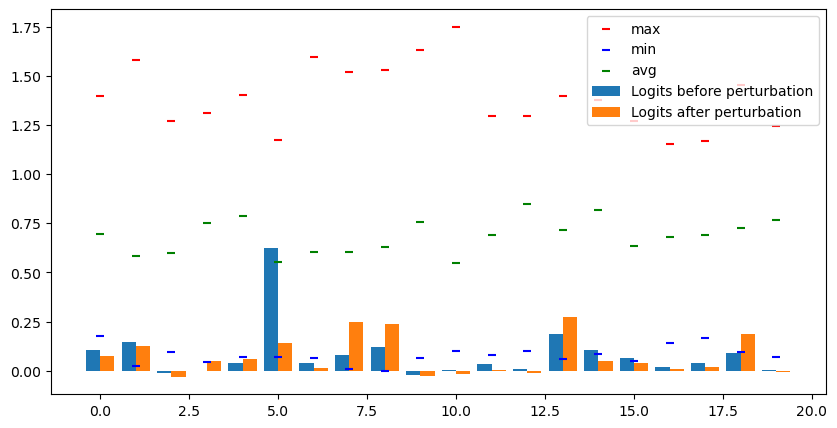

__________________________________________________________________________
__________________________________________________________________________


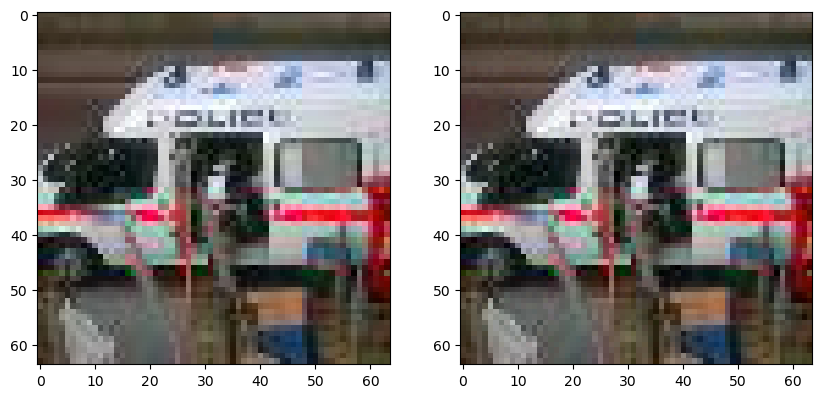

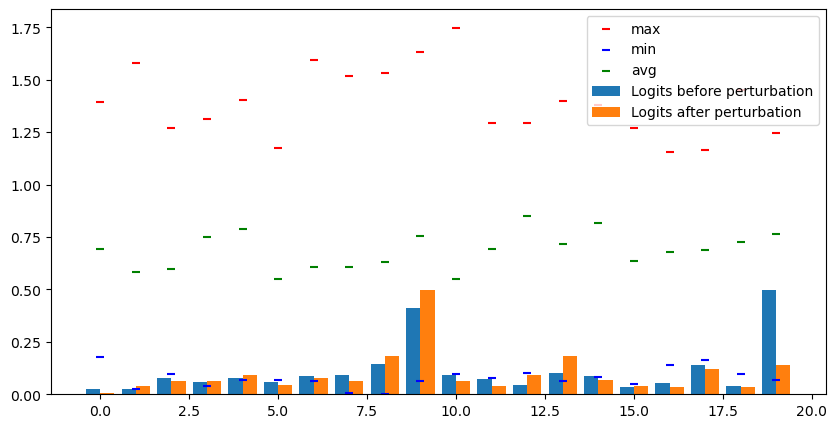

__________________________________________________________________________
__________________________________________________________________________


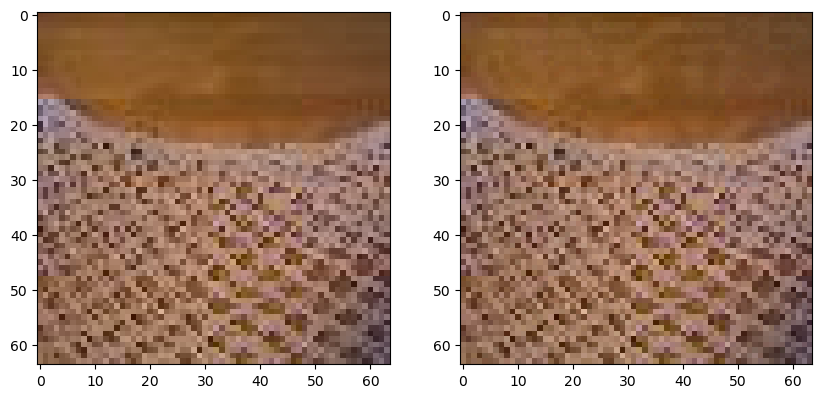

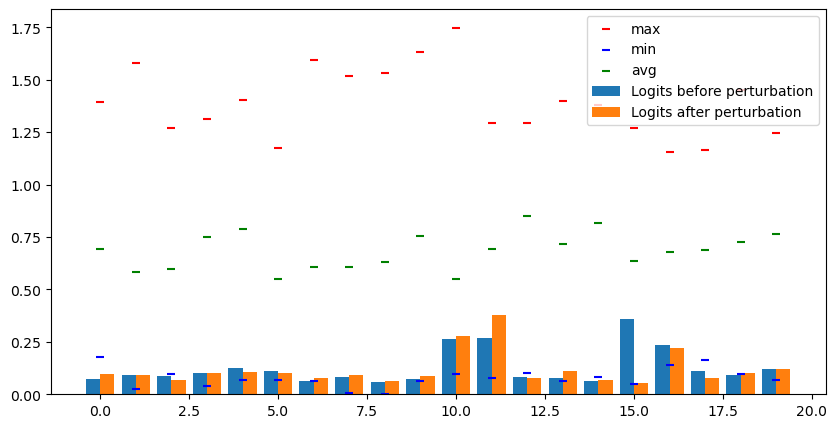

__________________________________________________________________________
__________________________________________________________________________


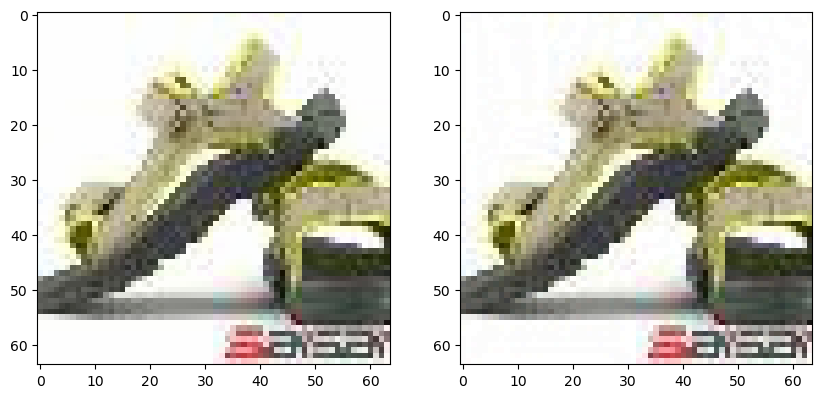

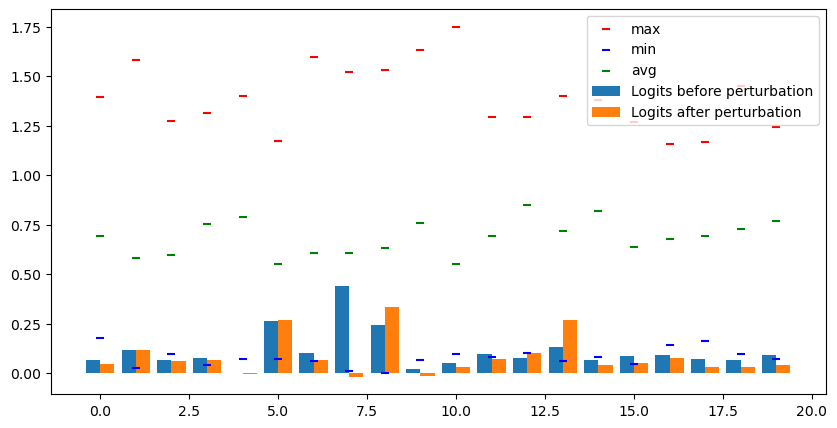

__________________________________________________________________________
__________________________________________________________________________


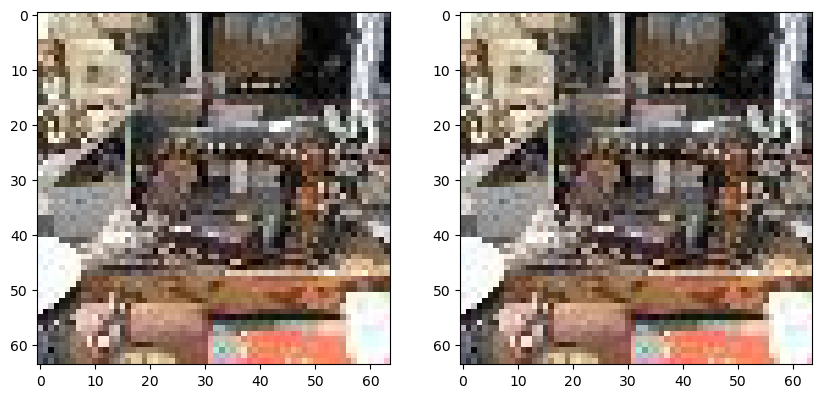

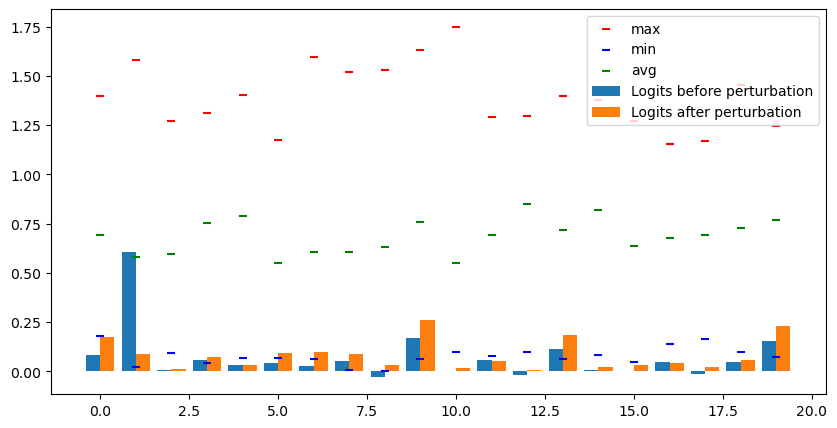

__________________________________________________________________________
__________________________________________________________________________


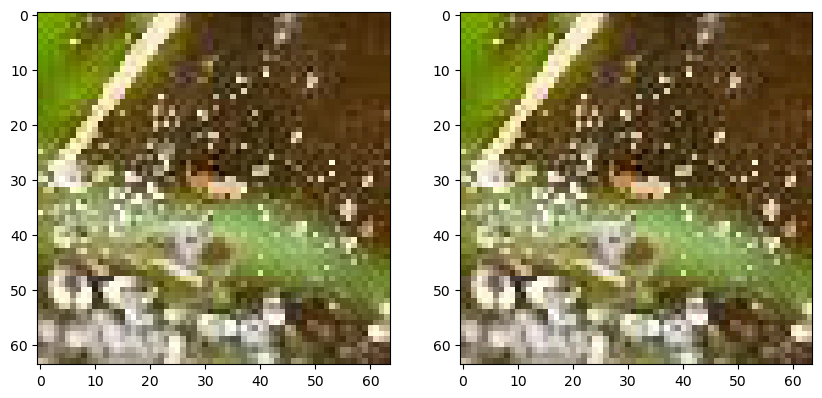

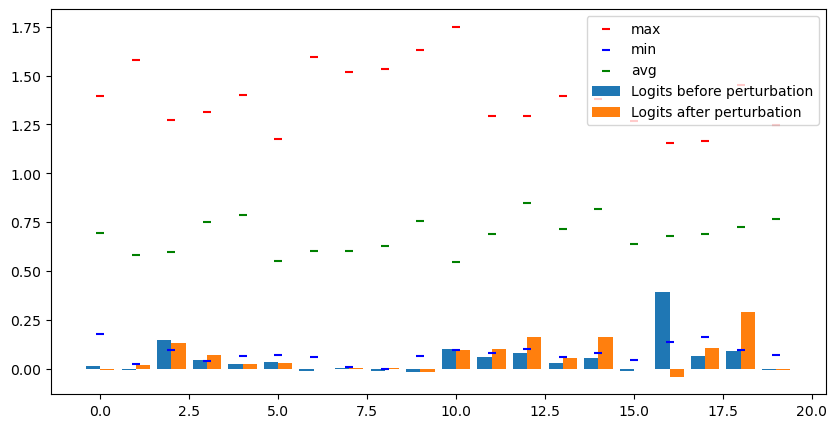

__________________________________________________________________________
__________________________________________________________________________


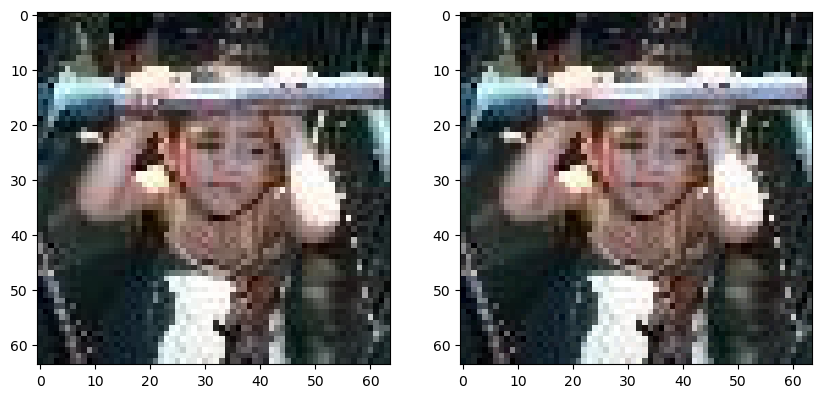

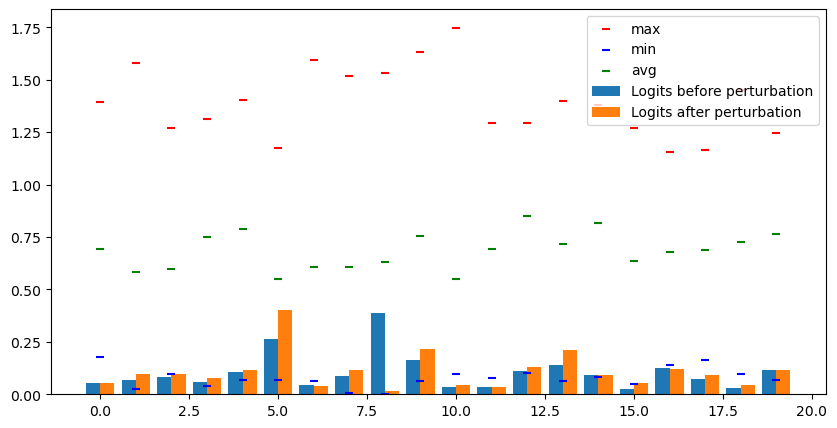

__________________________________________________________________________
__________________________________________________________________________


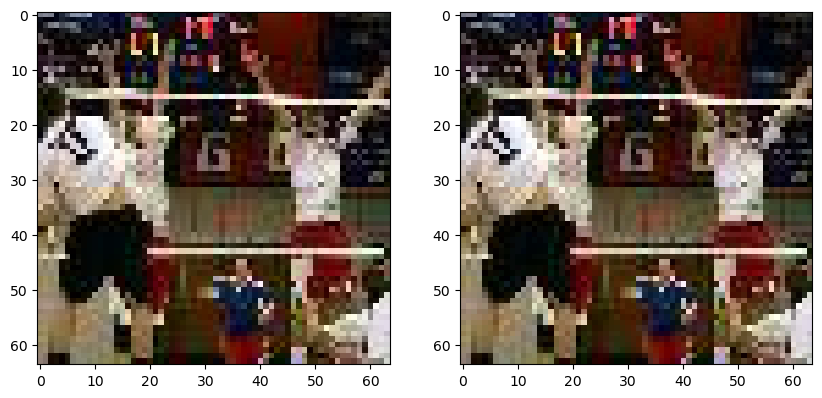

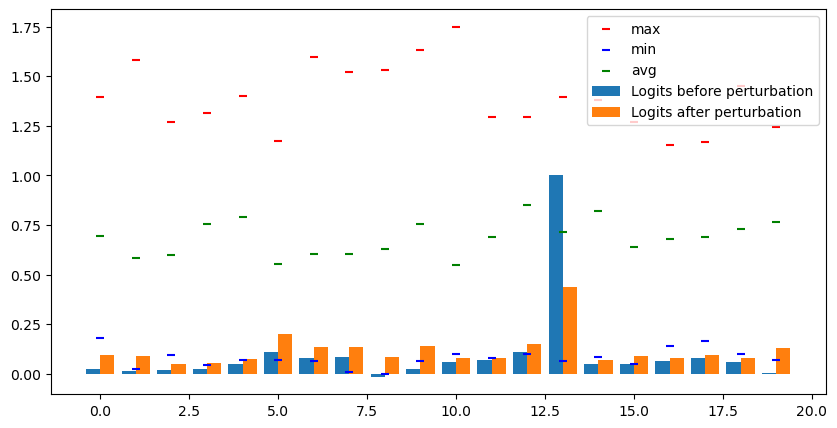

__________________________________________________________________________
__________________________________________________________________________


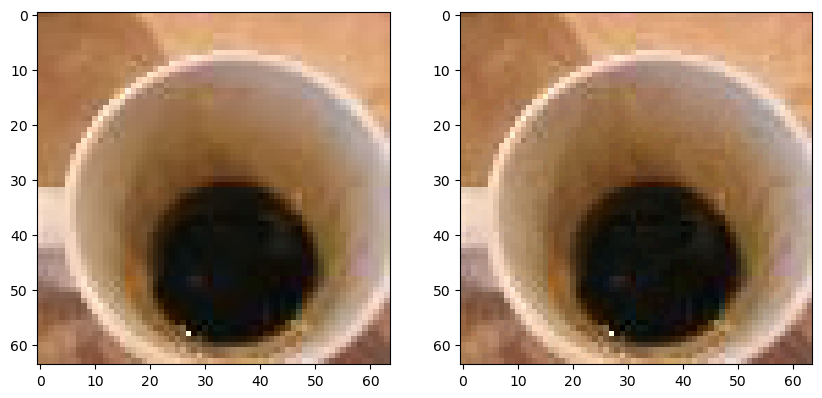

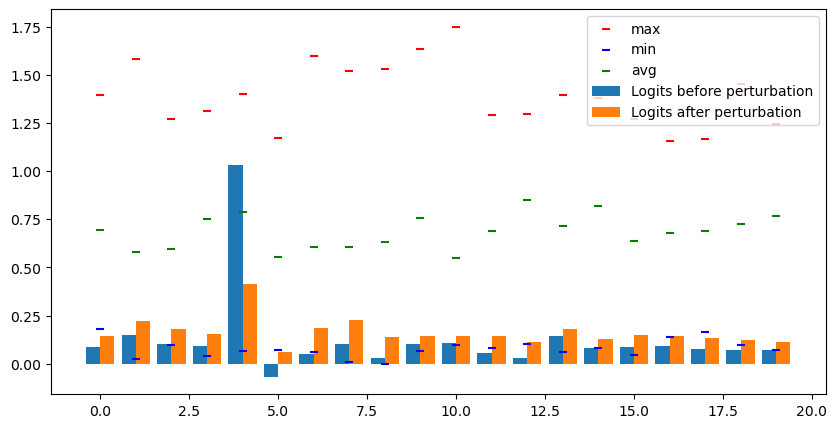

__________________________________________________________________________
__________________________________________________________________________


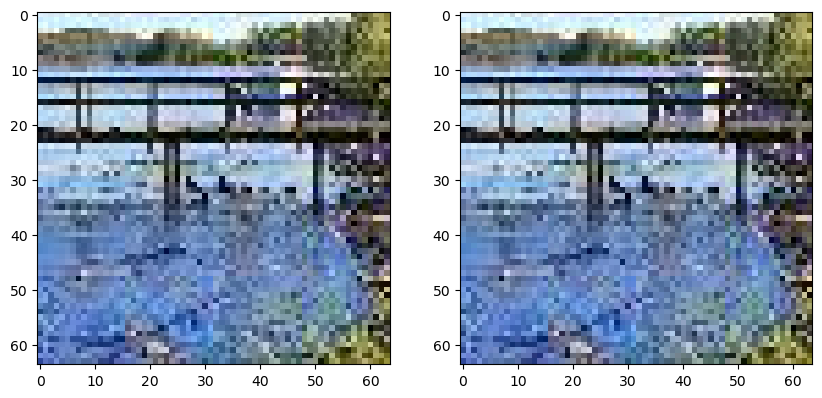

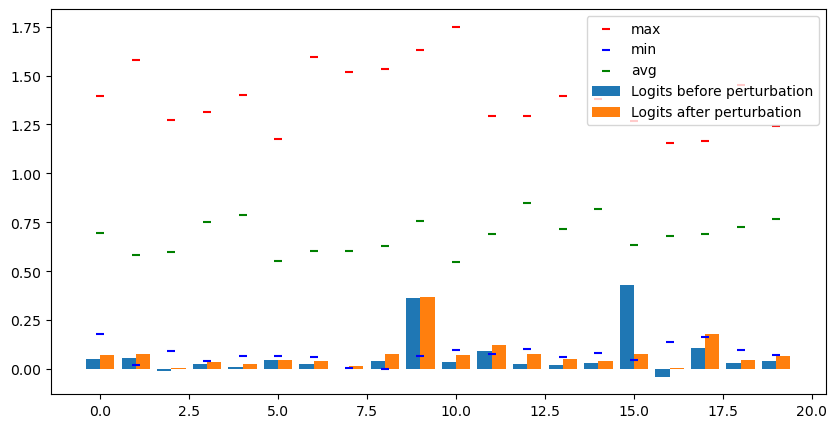

__________________________________________________________________________


In [21]:
show_k_adv_attacks_fn_osr(20, test_split_num, stats=test_stats)

# PCA

In [22]:
def get_features_for_pca(split_num):
    dataset = TinyImageNet(root=tin_val_root_dir, transform=test_transform)
    model = get_model_for_split(split_num, path_to_pretrained_weights_folder, device=device)
    dataloader = get_csr_dataloader_for_split(split_num, dataset, shuffle=False)
    #all_features = torch.zeros(len(dataloader.dataset), 128).detach()
    all_features = torch.tensor([])
    for i, (input_batch, target_batch, _) in enumerate(dataloader):
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        features = model(input_batch, return_feature=True)[0].detach().to('cpu') # MEMORY PROBLEMER
        all_features = torch.cat((all_features, features), dim=0)
        #all_features[i * dataloader.batch_size:(i+1) * dataloader.batch_size] = features
        print(f"{(i+1)/len(dataloader)*100}% done")
    
    dataset = TinyImageNet(root=tin_val_root_dir, transform=test_transform) # Overwriting because the other was modified in place.
    tiny_img_net_split = tiny_img_net_splits[split_num]
    os_classes = [x for x in range(200) if x not in tiny_img_net_split]
    os_examples = subsample_classes(dataset, os_classes)
    os_dataloader = DataLoader(os_examples, batch_size=100, shuffle=True)
    input_batch, target_batch , _ = next(iter(os_dataloader))
    input_batch = input_batch.to(device)
    os_features= model(input_batch, return_feature=True)[0].to('cpu')
    os_targets = torch.ones_like(target_batch) * (-777)
    return torch.cat((all_features,os_features), dim=0).detach(), torch.cat((torch.tensor(dataloader.dataset.targets),os_targets),dim=0).detach()

In [23]:
features_for_pca, targets_for_pca = get_features_for_pca(0)

10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done


In [24]:
standardized_features_for_pca = (features_for_pca - features_for_pca.mean(dim=0, keepdim=True)) / features_for_pca.std(dim=0, keepdim=True)

In [25]:
features_pca = PCA(n_components=2).fit_transform(features_for_pca.detach())
features_tsne = TSNE().fit_transform(features_for_pca.detach())
features_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(features_for_pca.detach(), targets_for_pca.detach())

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


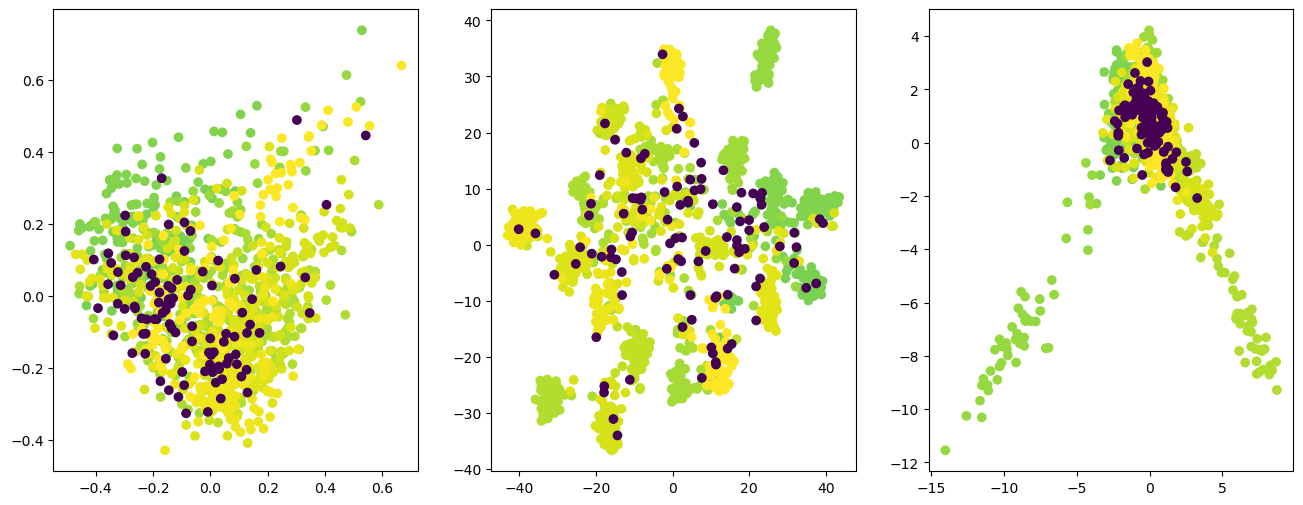

In [26]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
ax[0].scatter(features_pca[:, 0], features_pca[:, 1], c=targets_for_pca)
ax[1].scatter(features_tsne[:, 0], features_tsne[:, 1], c=targets_for_pca)
ax[2].scatter(features_lda[:, 0], features_lda[:, 1], c=targets_for_pca)
plt.show()

Saving all logits to disk

### Advesarial Attack logits

In [40]:
def evaluate_osr_auroc_adv_att(model, dataloader, split_num, adv_att, device=device, logdir=None):
    targets = []
    all_csr_targets = []
    mls_scores = []
    all_logits = []
    for i, (input_batch, target_batch, _) in enumerate(dataloader):
        all_csr_targets += target_batch,
        input_batch = input_batch.to(device)
        
        input_batch = adv_att(input_batch)
        
        target_batch = (~(sum(target_batch == i for i in tiny_img_net_splits[split_num]).bool()))
        target_batch = target_batch.to(device)
        logits = model(input_batch).detach().to('cpu')
        all_logits += logits,
        #logits = nn.Softmax(dim=-1)(logits) # Test for comparing with MSP
        mls_for_osr = -logits.max(dim=-1)[0] # (-) because low osr-score corresponds to known class
        targets += target_batch.tolist()
        mls_scores += mls_for_osr.tolist()
        print(f"{int((i+1)/len(dataloader)*100)}% done")

    if logdir is not None:
        torch.save(torch.cat(all_logits), logdir + "tin_vgg32_all_logit_scores_split_" + str(split_num) + ".pt")
        torch.save(all_csr_targets, logdir + "tin_vgg32_all_csr_targets_split_" + str(split_num) + ".pt")

    return roc_auc_score(targets, mls_scores)

def get_avg_osr_auroc_across_split_plus_adv_att(adv_att, path_to_pretrained_weights_folder=path_to_pretrained_weights_folder, device=device , logdir=None):
    aurocs = []
    for split_num in tqdm(range(5)):
        model = get_model_for_split(split_num, path_to_pretrained_weights_folder, device=device)
        dataloader = get_osr_dataloader_for_split(split_num)
        auroc = evaluate_osr_auroc(model, dataloader, split_num, adv_att, device=device, logdir=logdir)
        aurocs += auroc,
    
    return sum(aurocs)/len(aurocs)